In [41]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import networkx as nx
import seaborn as sns
import sys
import random
%matplotlib inline

#### Данные:

* Neutral Network

In [7]:
NN = nx.read_edgelist('../data/ca-netscience.txt')
print(round(nx.degree_assortativity_coefficient(NN), 4))

-0.0817


* Assortative Network

In [8]:
AS = nx.read_edgelist('../data/proteins.txt') 
print(round(nx.degree_assortativity_coefficient(AS), 4))

0.3968


* Disassortative Network

In [9]:
DS = nx.read_edgelist('../data/bio-yeast.txt') 
print(round(nx.degree_assortativity_coefficient(DS), 4))

-0.2095


#### 1. Матрица корреляций степеней вершин (3 балла)
* напишите функцию, вычисляющую матрицу корреляции степеней $e_{ij}$;
* напишите функцию, вычисляющую коэффициент ассортативности по матрице корреляций $e_{ij}$:
$$
r=\sum_{jk}\frac{jk\left[e_{jk}-q_jq_k\right]}{\sigma_q^2},
$$
$$
\sigma_q^2=\sum_k k^2q_k-(\sum_k kq_k)^2,
$$
$$
q_j=\sum_{i} e_{ji},
$$

* для заданных сетей постройте матрицы корреляций и вычислите коэффициент ассортативности, сравните со значениями, вычисленными с помощью [функции](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.assortativity.degree_assortativity_coefficient.html#networkx.algorithms.assortativity.degree_assortativity_coefficient).

In [14]:
def get_degree_correlation_matrix(G):
    degrees = dict(G.degree())
    max_degree = max(list(degrees.values()))
    E = np.zeros((max_degree + 1,  max_degree + 1))
    for i in G.edges():
        E[degrees[i[0]], degrees[i[1]]] += 1
        E[degrees[i[1]], degrees[i[0]]] += 1
    E /= np.sum(E)
    return E
    
def get_assortativity_from_E(E):
    n = len(E)
    q = np.sum(E, axis=1)
    s = np.sum(np.multiply(np.arange(1, len(q)+1)**2, q)) - np.sum(np.multiply(np.arange(1, len(q)+1), q))**2
    r = 0
    for j in range(n):
        for k in range(n):
            r += j * k * (E[j][k] - q[j] * q[k])
    r /= s
    return r

In [17]:
def compare(G):
    crafted_r = get_assortativity_from_E(get_degree_correlation_matrix(G))
    networkx_r = nx.degree_assortativity_coefficient(G)
    print(f'Crafted method: {crafted_r}\nNX method: { networkx_r}')

In [18]:
compare(NN)

Crafted method: -0.08167784834672827
NX method: -0.08167784834672846


In [19]:
compare(AS)

Crafted method: 0.39677721250363623
NX method: 0.39677721250363557


In [20]:
compare(DS)

Crafted method: -0.20954054116464865
NX method: -0.20954054116464868


In [24]:
def viz_E(E, net_name):
    plt.imshow(E, cmap='PiYG') # для визуализации матрицы корреляций
    plt.title(net_name)
    plt.colorbar()
    plt.show()

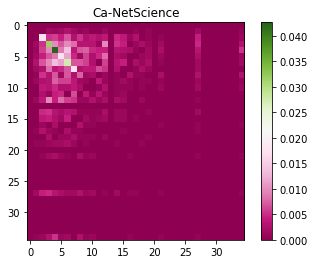

In [25]:
viz_E(get_degree_correlation_matrix(NN), 'Ca-NetScience Neutral Network')

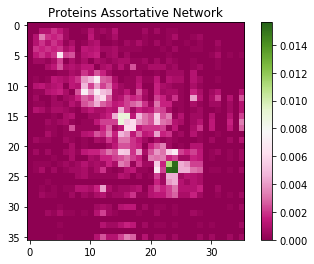

In [26]:
viz_E(get_degree_correlation_matrix(AS), 'Proteins Assortative Network')

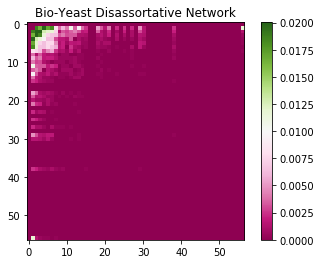

In [27]:
viz_E(get_degree_correlation_matrix(DS), 'Bio-Yeast Disassortative Network')

#### 2. Функция корреляции степеней (3 балла)
* напишите функцию, вычисляющую функцию корреляции $k_{nn}(k)$ для сети:
$$
k_{nn}(k)=\sum_{k'}k'P(k'|k)=\frac{\sum_i{k_{nn,i}}}{N(k)};
$$
$N(k)$ - число вершин степени $k$.
* постройте функции корреляций $k_{nn}(k)$ для заданных сетей. Аппроксимируйте в двойном логарифмическом масштабе полученные зависимости прямой:
$$
\log(k_{nn}(k))=\log(a)+\mu \log k
$$
Чему равны значения $\mu$ для разных сетей? 

In [30]:
def corr(G):
    knni = list(nx.average_neighbor_degree(G).values())
    degrees = dict(G.degree())
    degrees = dict(Counter(sorted(degrees.values())))
    knn = np.zeros(len(degrees.keys()))
    keys = list(degrees.keys())
    for i in range(len(knn)):
        k = degrees[keys[i]]
        knn[i] = np.sum(knni) / k
    return np.array(list(map(int, degrees.keys()))), np.array(knn)

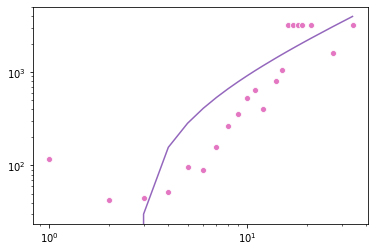

In [40]:
x, y = corr(NN)
sns.scatterplot(x, y, color='tab:pink')
coefs = np.polyfit(x, y, 1)
sns.lineplot(x, coefs[0]*x + coefs[1], color='tab:purple')
plt.yscale("log")
plt.xscale("log")
plt.show()

#### 3. Алгоритм [Xalvi-Brunet & Sokolov](https://en.wikipedia.org/wiki/Xulvi-Brunet%E2%80%93Sokolov_algorithm) (4 балла)
* измените функцию рандомизации сети (предыдущий семинар) так, чтобы рандомизированная сеть была ассортативна/диссортативна ($\rho=1$);

На каждом шаге из вершин $(P,Q), (R,S)$ соединяйте вершины наибольших степеней (ассортативность) или вершину наибольшей степени с вершиной наименьшей степени (диссортативность). Второе ребро соединяет оставшиеся вершины выбранной четверки. 
* проверьте, что алгоритм строит ассортативную/диссортативную сеть на случайных/реальных сетях. 

Исследуйте как влияет ассортативность сети на порог перколяции в случайных графах Эрдеша-Реньи:
* для разных значений $p \in\left[10^{-4},5  \centerdot 10^{-3} \right]$ сгенерируйте ансамбль случайных сетей $G(N,p)$, $N=10^3$, число сетей в ансамбле 10;
* постройте зависимость среднего значения гигантской компоненты в ансамбле как функцию $p$ (см. NS Seminar 03).
* с помощью вашего алгоритма сделайте сети ансамбля ассортативными/диссортативными;
* постройте зависимость среднего значения гигантской компоненты в ансамбле как функцию $p$ для смоделированных сетей (три зависимости на одном графике);

Как изменился порог перколяции? 

In [50]:
#ваш ход здесь
def randomize(G):
    pair_lambda = lambda x: each_pair[x] 
    new_list_lambda = lambda x: (pair1[x], pair2[x])
    list_of_edges = list(G.edges())

    for i in range(1000):
        random.shuffle(list_of_edges)
        paired_list = zip(list_of_edges, list_of_edges[1:])
        new_list = []
        for each_pair in paired_list:
            pair1,pair2 = pair_lambda(0),pair_lambda(1)
            new_list1,new_list2 = new_list_lambda(0),new_list_lambda(1)
            new_list.append(new_list1)
            new_list.append(new_list2)
        list_of_edges = new_list
    return list_of_edges

In [ ]:
randomize(NN)